In [2]:
from rodent_loss_src.doapr import read_and_filter_doapr
from pathlib import Path

ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]

tarpath = f'{PROJECTDIR}/milestones/data/doapr/sigdown_and_predictedTargets_tsM_tsH.tsv'
human_gopath = '/share/project/felixl/GO_database/goa_human.gaf'

## Parse organism specific GO database

In [10]:
import pandas as pd

def read_goa_gaf(path):
    gaf_columns = [
        "DB",
        "DB Object ID",
        "DB Object Symbol",
        "Qualifier",
        "GO ID",
        "DB:Reference (|DB:Reference)",
        "Evidence Code",
        "With (or) From",
        "Aspect",
        "DB Object Name",
        "DB Object Synonym (|Synonym)",
        "DB Object Type",
        "Taxon(|taxon)",
        "Date",
        "Assigned By",
        "Annotation Extension",
        "Gene Product Form ID",
    ]
    
    df = pd.read_csv(
        path, 
        sep='\t', 
        comment='!',
        names=gaf_columns
        )
    
    
    df = df.filter(['DB Object Symbol', 'GO ID', 'Evidence Code', 'DB Object Synonym (|Synonym)', 'Aspect'])
    return df

hu_gaf = read_goa_gaf(human_gopath)
display(hu_gaf)

/tmp/ipykernel_1374199/593300211.py:24: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,DB Object Symbol,GO ID,Evidence Code,DB Object Synonym (|Synonym),Aspect
0,NUDT4B,GO:0003723,IEA,NUDT4B,F
1,NUDT4B,GO:0046872,IEA,NUDT4B,F
2,NUDT4B,GO:0005829,IDA,NUDT4B,C
3,IGKV3-7,GO:0002250,IEA,IGKV3-7,P
4,IGKV3-7,GO:0005886,IEA,IGKV3-7,C
...,...,...,...,...,...
626131,UNC13B,GO:0061789,IBA,UNC13B|UNC13,P
626132,NPIPB7,GO:0005654,IBA,NPIPB7|NPIPL1,C
626133,FOXO4,GO:0000981,IBA,FOXO4|AFX|AFX1|MLLT7,F
626134,OR10T2,GO:0004984,IBA,OR10T2,F


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


def count_goterms_per_gene(gafdf):
    # Count number of terms associated with each gene per GO-Aspect (cellular compononent, molecular function, biologcial process)
    dfs = []
    for aspect in gafdf.Aspect.unique():
        df = gafdf[gafdf['Aspect'] == aspect]
        df = df.filter(['DB Object Symbol', 'GO ID']).drop_duplicates()

        countdf = pd.DataFrame.from_dict(
            dict(Counter(df['DB Object Symbol'])),
            orient='index',
            columns=[aspect]
            )
        dfs.append(countdf)
    
    # Iteratively merge DataFrames
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.merge(df, left_index=True, right_index=True, how='outer')
        
    # fill NaN with zero count and calculate sum
    combined_df = combined_df.fillna(0).astype(int)
    combined_df['sum_go'] = combined_df.sum(axis=1)
    
    # Remove counts of GO-terms associated with genes without a gene name
    combined_df = combined_df[combined_df.index.notna()]
    
    return combined_df
    
hu_go_count = count_goterms_per_gene(hu_gaf)
display(hu_go_count)

,F,C,P,sum_go
A0A0G2JMS6,1,1,1,3
A0A0G2JNH3,1,0,2,3
A0A0G2JPB7,1,1,2,4
A0A1B0GTQ1,4,1,0,5
A0A1B0GUZ9,0,1,0,1
...,...,...,...,...
ZYG11A,0,1,0,1
ZYG11B,1,1,2,4
ZYX,3,8,7,18
ZZEF1,6,0,1,7


## Load set of primary targets

In [53]:
def enumerate_goterms_candidate_genes(go_count):
    condition2gocount = {}
    for organism in ORGANISMS:
        for mirna in MIRNAS:
            condition = f'{organism}|{mirna}'
            targetdf = read_and_filter_doapr(tarpath, organism, mirna, targetscan_cutoff=-0.2)
            doapr = [gene.upper() for gene in targetdf.index]
            doapr = [gene for gene in doapr if gene in go_count.index]

            condition2gocount[condition] = go_count.loc[doapr]
    return condition2gocount
            
            
condition2gocount = enumerate_goterms_candidate_genes(hu_go_count)

## Plot sum of GO-terms

In [73]:
df = hu_go_count.filter(['sum_go'])
df['label'] = 'background'
df = df.reset_index()

col = [df]
for condition, df in condition2gocount.items():
    df = df.filter(['sum_go'])
    df['label'] = condition
    df = df.reset_index()
    col.append(df)
    # sumdf = sumdf.merge(df, left_index=True, right_index=True, how='outer')

sumdf = pd.concat(col)
display(sumdf)

,index,sum_go,label
0,A0A0G2JMS6,3,background
1,A0A0G2JNH3,3,background
2,A0A0G2JPB7,4,background
3,A0A1B0GTQ1,5,background
4,A0A1B0GUZ9,1,background
...,...,...,...
12,PEX11A,11,mouse|mir769
13,FUT11,6,mouse|mir769
14,FLOT1,58,mouse|mir769
15,TBC1D2,12,mouse|mir769


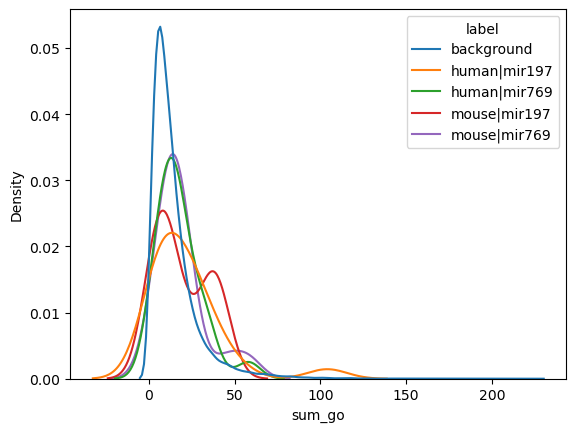

In [84]:
sns.kdeplot(data=sumdf, x='sum_go', hue='label', common_norm=False)
plt.show()